In [1]:
import torch
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('/Users/carlitos/Desktop/ProteinDesign/ProteinDesign/pdb_data_seq.csv')
protein_seq = df.query('macromoleculeType == "Protein"')['sequence']
print(protein_seq)
# we only need 20k protein sequences
protein_seq = protein_seq[:20000].reset_index(drop=True)
print(protein_seq)
# drop nan
protein_seq = protein_seq.dropna()
len(protein_seq)
# convert to list of protein sequences
proteins = protein_seq.tolist()
proteins[:3]

4         MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
7         MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
8         MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
11        MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...
12        MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
                                ...                        
467299    MNYQPTPEDRFTFGLWTVGWQGRDPFGDATRRALDPVESVQRLAEL...
467300    SVQATREDKFSFGLWTVGWQARDAFGDATRTALDPVEAVHKLAEIG...
467301    SVQATREDKFSFGLWTVGWQARDAFGDATRTALDPVEAVHKLAEIG...
467302    SVQATREDKFSFGLWTVGWQARDAFGDATRTALDPVEAVHKLAEIG...
467303    SVQATREDKFSFGLWTVGWQARDAFGDATRTALDPVEAVHKLAEIG...
Name: sequence, Length: 345180, dtype: object
0        MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
1        MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
2        MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
3        MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...
4        MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...

['MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRVKHLKTEAEMKASEDLKKHGVTVLTALGAILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGNFGADAQGAMNKALELFRKDIAAKYKELGYQG',
 'MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSELDKAIGRNTNGVITKDEAEKLFNQDVDAAVRGILRNAKLKPVYDSLDAVRRAALINMVFQMGETGVAGFTNSLRMLQQKRWDEAAVNLAKSRWYNQTPNRAKRVITTFRTGTWDAYKNL',
 'MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRFKHLKTEAEMKASEDLKKAGVTVLTALGAILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGNFGADAQGAMNKALELFRKDIAAKYKELGYQG']

In [3]:
# build a vocabulary of mapping the aa to integers
aa = list(set(''.join(proteins)))
stoi = {s:i+1 for i,s in enumerate(aa)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'P', 2: 'V', 3: 'U', 4: 'N', 5: 'R', 6: 'G', 7: 'M', 8: 'C', 9: 'F', 10: 'E', 11: 'L', 12: 'I', 13: 'D', 14: 'W', 15: 'Z', 16: 'K', 17: 'Q', 18: 'T', 19: 'H', 20: 'X', 21: 'S', 22: 'Y', 23: 'A', 0: '.'}
24


In [71]:
# let's build the dataset
block_size = 8 # context length

def build_dataset(proteins):
  X, Y = [], []

  for protein in proteins:
    #print(protein)
    context = [0] * block_size
    for aa in protein + '.':
      ix = stoi[aa]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(proteins)
n1 = int(0.8*len(proteins))
n2 = int(0.9*len(proteins))

Xtr, Ytr = build_dataset(proteins[:n1])      # 80%
Xdev, Ydev = build_dataset(proteins[n1:n2])  # 10%
Xte, Yte = build_dataset(proteins[n2:])      # 10%

torch.Size([3799190, 8]) torch.Size([3799190])
torch.Size([469943, 8]) torch.Size([469943])
torch.Size([475834, 8]) torch.Size([475834])


In [75]:
for x, y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '--->', itos[y.item()])

........ ---> A
.......A ---> F
......AF ---> V
.....AFV ---> V
....AFVV ---> T
...AFVVT ---> D
..AFVVTD ---> N
.AFVVTDN ---> C
AFVVTDNC ---> I
FVVTDNCI ---> K
VVTDNCIK ---> C
VTDNCIKC ---> K
TDNCIKCK ---> Y
DNCIKCKY ---> T
NCIKCKYT ---> K
CIKCKYTK ---> C
IKCKYTKC ---> V
KCKYTKCV ---> E
CKYTKCVE ---> V
KYTKCVEV ---> C


In [137]:
# -----------------------------------------------------------------------------------------------
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:
  
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
    
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:

  def __init__(self, n):
    self.n = n
      
  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    self.out = x.view(x.shape[0], -1)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

In [138]:
torch.manual_seed(42); # seed rng for reproducibility

In [139]:
# original network
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 68 # the number of neurons in the hidden layer of the MLP

model = Sequential([
    Embedding(vocab_size, n_embd), 
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden* 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

22160


In [140]:
model.layers[3].running_mean.shape

torch.Size([68])

In [141]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb) # forward pass
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.01 if i < 150000 else 0.001 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.1709
  10000/ 200000: 2.8884
  20000/ 200000: 3.0403
  30000/ 200000: 2.9314
  40000/ 200000: 2.8834
  50000/ 200000: 2.8773
  60000/ 200000: 2.9209
  70000/ 200000: 2.8910
  80000/ 200000: 2.8757
  90000/ 200000: 2.7268
 100000/ 200000: 2.9475
 110000/ 200000: 2.8073
 120000/ 200000: 2.7508
 130000/ 200000: 2.9448
 140000/ 200000: 2.9698
 150000/ 200000: 2.8444
 160000/ 200000: 2.8632
 170000/ 200000: 3.0057
 180000/ 200000: 2.9167
 190000/ 200000: 2.9202


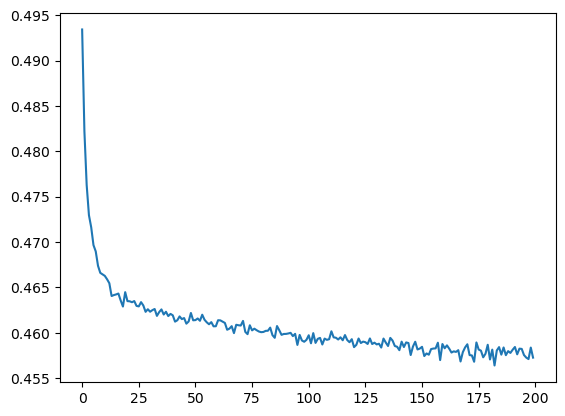

In [142]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [143]:
# put the layers into eval mode
for layer in model.layers:
  layer.training = False

In [144]:
# Evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.867023468017578
val 2.864173650741577


## Performance log
- original(3 aa context + 200 hidden neurons, 11k params): train 2.89, val 2.89
- context: 3 --> 8 (21k params): train 2.871, val 2.868
- flat --> hierarchical (21k params): train 2.869, val 2.866
- fix bug batchnorm: train 2.867, val 2.864

In [70]:
# sample from the model
for _ in range(3):

  out = []
  context = [0] * block_size
  while True:
    # forward pass of the neural net
    logits = model(torch.tensor([context]))
    probs = F.softmax(logits, dim=1)
    # sample from the distribution
    ix = torch.multinomial(probs, num_samples=1).item()
    # shift the context window and track the samples
    context = context[1:] + [ix]
    out.append(ix)
    # if we sample the special '.' token, break
    if ix == 0:
      break

  print(''.join(itos[i] for i in out)) # decode and print the generated protein

ISSLPALWAGCDRENLDRVKVTGLELELWLDMSLTASFTSRRCPLGLVWGQAGRGYEAKVALHEKSAALERGKHHAHRVMAPELHSDEDISGADPLGEAVGEASASKEDPLQ.
EMVAMKADLGAAANLKEFIVDPPDPDWYGNHMGTATILQVDGLPTRELSDSDWSYNYTLQVGICEVGFFRMHGQGLKLLRSSEPSDLYRRGKQEYREASAHPGPFNAYLREVFPPKSEPAFHYWKKSQKVDTCIYNMISAAVL.
MDLVKLRTQDEATSDWSVVPEDDAIIAFPKVNAWIEAAANLMDDAVGDAPKSMLNF.
